<a href="https://colab.research.google.com/github/BrianGirardiRice/Public/blob/main/HW5Question_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import sys
sys.meta_path[:] = [f for f in sys.meta_path if "DaskFinder" not in str(f)]

!pip install numpy==1.26.4

!pip install pennylane
import pennylane as qml




import pennylane as qml
import matplotlib.pyplot as plt
from pennylane import numpy as np


#import numpy as np
from collections import Counter
from itertools import combinations
import random
import networkx as nx
print("yay")




yay


/usr/local/lib/python3.11/dist-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


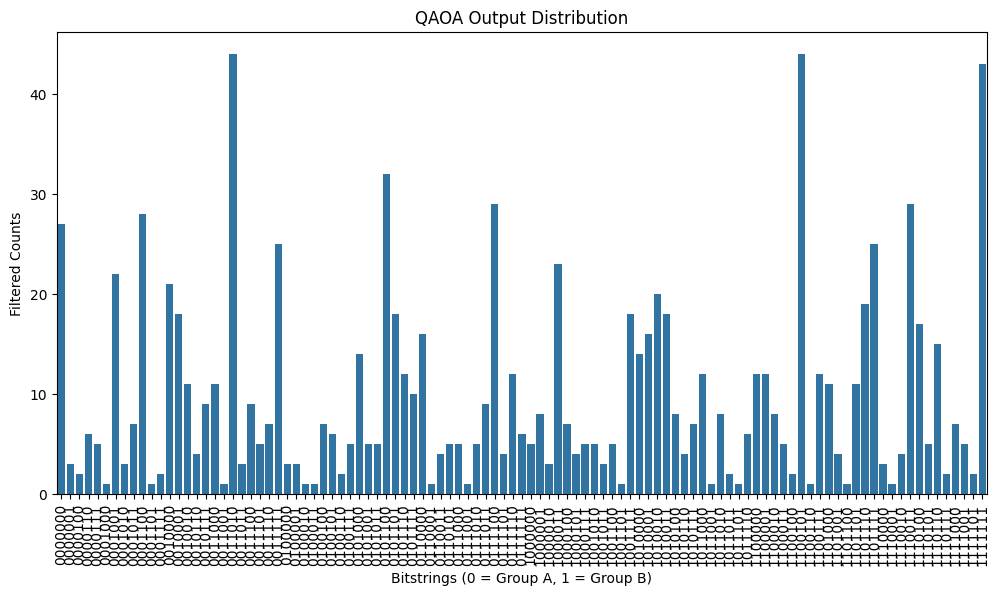

In [19]:
'''
0 - North America
1 - South America
2 - Antarctica
3 - Europe
4 - Africa
5 - Australia
6 - Asia
'''

n_qubits = 7
dev = qml.device("default.qubit", wires=n_qubits, shots=1000)

#Similarity index matrix
W = np.array([
    [0, 3.1, 2.0, 4.5, 5.0, 1.2, 2.7],
    [3.1, 0, 1.8, 3.8, 4.7, 1.5, 2.9],
    [2.0, 1.8, 0, 1.6, 1.7, 2.3, 1.9],
    [4.5, 3.8, 1.6, 0, 4.9, 1.4, 5.1],
    [5.0, 4.7, 1.7, 4.9, 0, 1.1, 5.4],
    [1.2, 1.5, 2.3, 1.4, 1.1, 0, 1.6],
    [2.7, 2.9, 1.9, 5.1, 5.4, 1.6, 0],
])

edges = [(i, j, W[i][j]) for i in range(n_qubits) for j in range(i) if W[i][j] > 0]

def cost_layer(gamma):
    for i, j, w in edges:
        qml.CNOT(wires=[i, j])
        qml.RZ(-gamma * w, wires=j)
        qml.CNOT(wires=[i, j])

def mixer_layer(beta):
    for i in range(n_qubits):
        qml.RX(2*beta, wires=i)

@qml.qnode(dev)
def qaoa_circuit(gammas, betas):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    for gamma, beta in zip(gammas, betas):
        cost_layer(gamma)
        mixer_layer(beta)
    return qml.sample()

def cost_function(bitstrings):
    total = 0
    for b in bitstrings:
        cut_value = 0
        for i, j, w in edges:
            cut_value += w
        total += cut_value
    return total / len(bitstrings)

# Optimize QAOA
p = 2  # number of layers
np.random.seed(42)
gammas = np.random.uniform(0, np.pi, p)
betas = np.random.uniform(0, np.pi, p)

opt = qml.optimize.AdamOptimizer(stepsize=0.1)
steps = 100

for i in range(steps):
    params, cost = opt.step_and_cost(
        lambda x: -cost_function(qaoa_circuit(x[:p], x[p:])),
        np.concatenate([gammas, betas])
    )
    gammas, betas = params[:p], params[p:]

# Get final distribution
samples = qaoa_circuit(gammas, betas)
unique, counts = np.unique(samples, axis=0, return_counts=True)

raw_counts = {
    ''.join(str(b) for b in u): c
    for u, c in zip(unique, counts)
}

# Filter for 3–4 splits
filtered_counts = {
    b: c for b, c in raw_counts.items()
    if b.count('1') == 4
}

# Show final histogram
import seaborn as sns

bitstrings = [''.join(str(b) for b in u) for u in unique]
plt.figure(figsize=(12, 6))
#sns.barplot(x=list(filtered_counts.keys()), y=list(filtered_counts.values()))
sns.barplot(x=list(raw_counts.keys()), y=list(raw_counts.values()))
plt.xticks(rotation=90)
plt.xlabel("Bitstrings (0 = Group A, 1 = Group B)")
plt.ylabel("Raw Counts")
plt.ylabel("Filtered Counts")
plt.title("QAOA Output Distribution")
plt.show()
